# Deep Learning for NLP - Project

Done with Python 3.6

In [1]:
%load_ext autoreload
%autoreload 2
import io
import os
import numpy as np
import scipy
from utils import *

In [2]:
PATH_TO_DATA = "data/"
SST_DIR = os.path.join(PATH_TO_DATA,'SST')

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        self.words = np.asarray([*self.word2vec.keys()])
        self.size = len(self.word2vec[self.words[0]])
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort
        list_score = [self.score(w, w_dico) for w_dico in self.word2vec]
        if np.max(list_score) == 0:
            return []
        
        index_best_words = np.argsort(list_score)[::-1][:K]
        return self.words[index_best_words].tolist()

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        if not w1 in self.word2vec or not w2 in self.word2vec:
            return 0
        emb1 = self.word2vec[w1]
        emb2 = self.word2vec[w2]
        return emb1.dot(emb2.T)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))


In [36]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)

# You will be evaluated on the output of the following:
print("\n\nA few scores...")
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))

print("\n\nThe most similar words...")
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    best_matches = w2v.most_similar(w1)
    print(f"{w1}: {', '.join(best_matches)}")

Loaded 25000 pretrained word vectors


A few scores...
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0
germany berlin 0


The most similar words...
cat: cat, cats, kitty, kitten, Cat
dog: dog, dogs, puppy, Dog, canine
dogs: dogs, dog, Dogs, puppies, cats
paris: 
germany: 


In [4]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        sentemb = []
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                embeddings = [self.w2v.word2vec[w] for w in sent if w in w2v.word2vec]
                if len(embeddings) == 0: #if any word in the sentence is in our lookup table
                    sentemb.append(np.zeros(self.w2v.size))
                else:
                    sentemb.append(np.mean(embeddings, axis=0))
            else:
                # idf-weighted mean of word vectors
                embeddings = [idf[w]*self.w2v.word2vec[w] for w in sent if w in w2v.word2vec and w in idf]
                if len(embeddings) == 0: #if any word in the sentence is in our lookup table
                    sentemb.append(np.zeros(self.w2v.size))
                else:
                    sentemb.append(np.mean(embeddings, axis=0))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        list_score = [self.score(s, sentence, idf) for sentence in sentences]
        index_best_sent = (np.argsort(list_score)[::-1][:K])
        if max(list_score) == 0:
            print(f"Oops... The words are unkwnown in the sentence {s}!")
            return []
        
        all_sent = []
        print(f'Best {K} matches of "{s}"')
        for i, idx in enumerate(index_best_sent):
            print(f'{i}: {sentences[idx]}')
            all_sent.append(sentences[idx])
        return all_sent
    

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        emb1, emb2 = self.encode([s1, s2], idf)
        if np.linalg.norm(emb1) == 0 or np.linalg.norm(emb2) == 0:
             return 0
        return emb1.dot(emb2.T)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
        
                                           
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1        
        for w in idf:
            idf[w] = max(1, np.log10(len(sentences) / (idf[w])))
        return idf

In [64]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)
s2v = BoV(w2v)

# Load sentences

with open(os.path.join(PATH_TO_DATA, 'sentences.txt')) as f:
    sentences = f.readlines()

# # You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
score = s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13])
print(f"Score without IDF is {score}")

# # Build idf scores for each word
idf = s2v.build_idf(sentences) 
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
score = s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf)
print(f"Score with IDF is {score}")

Loaded 25000 pretrained word vectors
Best 5 matches of "1 smiling african american boy . 
"
0: 1 smiling african american boy . 

1: an african american male is singing into a microphone . 

2: an african american man is jumping in the air , while a boy claps . 

3: a man in brown is helping a man in red climb a rock . 

4: a smiling woman carrying her baby in a sling . 

Score without IDF is 0.9564367613713493
Best 5 matches of "1 smiling african american boy . 
"
0: 1 smiling african american boy . 

1: an african american man is jumping in the air , while a boy claps . 

2: an african american male is singing into a microphone . 

3: a man rock climbing in a forest . 

4: a man in brown is helping a man in red climb a rock . 

Score with IDF is 0.9562052331058694


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [5]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
try:
    from urllib import urlretrieve
except ImportError:
    from urllib.request import urlretrieve

files = ["wiki.en.vec", "wiki.fr.vec"]
urls = ["https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec",
       "https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec"]

for f, u in zip(files, urls):
    if not os.path.isfile(os.path.join(PATH_TO_DATA, f)):
        print("Downloading", f)
        urlretrieve(u, os.path.join(PATH_TO_DATA, f))

w2v_eng = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
w2v_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [7]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

common = [w for w in w2v_eng.word2vec if w in w2v_fr.word2vec]
X = np.vstack([w2v_eng.word2vec[w] for w in common])
Y = np.vstack([w2v_fr.word2vec[w] for w in common])

In [8]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

from scipy import linalg as LA

# TYPE CODE HERE
X = X[:100]
Y = Y[:100]
U, S, V = LA.svd(Y.dot(X.T))
W = U.dot(V)

In [15]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

from scipy.linalg import svd
from IPython.display import HTML, display
from tabulate import tabulate

def compute_mapping(w2v_1, w2v_2, nmax):
    common = [w for w in w2v_1.word2vec if w in w2v_2.word2vec]
    common = common[:nmax]
    X = np.vstack([w2v_1.word2vec[w] for w in common]).T
    Y = np.vstack([w2v_2.word2vec[w] for w in common]).T
    U, s, Vh = svd(Y.dot(X.T))
    return U.dot(Vh)
    
    
def most_similar(word, native, foreign, W, K=5):
    emb_native = W.dot(native.word2vec[word]) if word in native.word2vec else 0
    list_score = [score(emb_native, emb_foreign) 
                      for _, emb_foreign in foreign.word2vec.items()]
    index_best_words = np.argsort(list_score)[::-1][:K]
    return np.asarray([*foreign.word2vec.keys()])[index_best_words]

def score(emb1, emb2):
    if np.linalg.norm(emb1) == 0 or np.linalg.norm(emb2) == 0:
        return 0
    else:
        return emb1.dot(emb2.T)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
    
W1 = compute_mapping(w2v_fr, w2v_eng, 25000) 
W2 = compute_mapping(w2v_eng, w2v_fr, 25000) 
french_words = ['chien', 'ville', 'film', 'septembre', 'roi']
english_words = ['dog', 'women', 'television', 'car', 'king']

table_fr = [[w, *most_similar(w, w2v_fr, w2v_eng, W1)] for w in french_words]
table_fr = np.asarray(table_fr).T
table_eng = [[w, *most_similar(w, w2v_eng, w2v_fr, W2)] for w in english_words]
table_eng = np.asarray(table_eng).T

display(HTML(tabulate(table_fr[1:],table_fr[0], tablefmt="html")))
display(HTML(tabulate(table_eng[1:],table_eng[0], tablefmt="html")))

chien,ville,film,septembre,roi
dog,city,film,june,king
poodle,town,movie,april,vassal
terrier,cities,films,september,kingship
dogs,suburb,screenplay,october,throne
spaniel,towns,writer/director,november,usurper


dog,women,television,car,king
dog,femmes,télévision,voiture,roi
chien,women,television,voitures,king
hound,féminines,télévisuelle,automobile,rois
chiens,féministes,télévisés,porsche,reine
chienne,féminine,télévisées,automobiles,trône


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [5]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

x_train,y_train = decode_with_labels(os.path.join(SST_DIR, 'stsa.fine.train'))
x_dev,y_dev = decode_with_labels(os.path.join(SST_DIR,'stsa.fine.dev'))
x_test = decode_without_labels(os.path.join(SST_DIR, 'stsa.fine.test.X'))

In [6]:
# 2 - Encode sentences with the BoV model above
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=1000000)
s2v = BoV(w2v)

idf = s2v.build_idf(x_train)

x_train_idf = s2v.encode(x_train,idf)
x_dev_idf = s2v.encode(x_dev,idf)

x_train = s2v.encode(x_train)
x_dev = s2v.encode(x_dev)
x_test = s2v.encode(x_test)

Loaded 1000000 pretrained word vectors


In [56]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

regularizers = np.arange(0.1, 1.0, 0.1)
lr = [LogisticRegression(C=c, multi_class='auto', max_iter=1000, solver='lbfgs', n_jobs=4, tol=1e-8) for c in regularizers]

[model.fit(x_train, y_train) for model in lr]
scores = [accuracy_score(y_dev, model.predict(x_dev)) for model in lr]
print(f'Without IDF, the best score is {np.max(scores):.2f} with L2 regularization {regularizers[np.argmax(scores)]}')

[model.fit(x_train_idf, y_train) for model in lr]
scores = [accuracy_score(y_dev, model.predict(x_dev_idf)) for model in lr]
print(f'With IDF, the best score is {np.max(scores):.2f} with L2 regularization {regularizers[np.argmax(scores)]}')

Without IDF, the best score is 0.41 with L2 regularization 0.30000000000000004
With IDF, the best score is 0.41 with L2 regularization 0.1


In [59]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

best_c = 0.3
lr = LogisticRegression(C=best_c, multi_class='auto', max_iter=1000, solver='lbfgs', n_jobs=4, tol=1e-8)
lr.fit(x_train, y_train)
y_test = lr.predict(x_test)
lines = '\n'.join([str(p) for p in y_test])
with open('logreg_bov_y_test_sst.txt','w+') as f:
    f.writelines(lines)

In [21]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from IPython.display import HTML, display
from tabulate import tabulate

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3, n_jobs=4),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=1, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=10, n_estimators=100, max_features=1, n_jobs=4),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

results = {}

for name, clf in zip(names, classifiers):
    clf.fit(x_train,y_train)
    prediction = clf.predict(x_dev)
    results[name] = accuracy_score(y_dev, prediction)
    
display(HTML(tabulate([[*results.values()]], [*results.keys()], tablefmt="html")))

Nearest Neighbors,Linear SVM,RBF SVM,Decision Tree,Random Forest,Neural Net,AdaBoost,Naive Bayes,QDA
0.322434,0.360581,0.428701,0.326067,0.348774,0.400545,0.362398,0.378747,0.352407


In [24]:
clf = SVC(gamma=1, C=1)
clf.fit(x_train, y_train)
y_test = clf.predict(x_test)
lines = '\n'.join([str(p) for p in y_test])
with open('rbf_svm_bov_y_test_sst.txt','w+') as f:
    f.writelines(lines)

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [3]:
import keras
from keras.preprocessing.text import one_hot
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [4]:
# 1 - Load train/dev/test sets of SST
x_train, y_train = decode_with_labels(os.path.join(SST_DIR, 'stsa.fine.train'))
x_dev, y_dev = decode_with_labels(os.path.join(SST_DIR,'stsa.fine.dev'))
x_test = decode_without_labels(os.path.join(SST_DIR, 'stsa.fine.test.X'))

In [5]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function

list_words = set([w for sentences in x_train + x_dev + x_test  for w in sentences])
n_words = len(list_words)

X_train = [one_hot(' '.join(x), n_words) for x in x_train]
X_dev = [one_hot(' '.join(x), n_words) for x in x_dev]
X_test = [one_hot(' '.join(x), n_words) for x in x_test]

Y_train = to_categorical(y_train)
Y_dev = to_categorical(y_dev)
print("Y:", Y_train.shape)

Y: (8544, 5)


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [6]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/
max_len = np.max([len(line) for line in x_train + x_dev + x_test])

X_train = pad_sequences(X_train, maxlen=max_len)
X_dev = pad_sequences(X_dev, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
print("X:", X_train.shape)

X: (8544, 56)


## 4.2 - Design and train your model

In [28]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, SpatialDropout1D

embed_dim  = 32  # word embedding dimension
nhid = 32  # number of hidden units in the LSTM
vocab_size = n_words  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))


In [29]:
# 5 - Define your loss/optimizer/metrics

loss_classif = 'categorical_crossentropy' # find the right loss for multi-class classification
optimizer = 'adam' # find the right optimizer
metrics_classif = ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 32)          638112    
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, None, 32)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 165       
Total params: 646,597
Trainable params: 646,597
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
from keras_tqdm import TQDMCallback, TQDMNotebookCallback

bs = 64
n_epochs = 6
history = model.fit(X_train, Y_train, batch_size=bs, 
                        epochs=n_epochs, 
                        validation_data=(X_dev, Y_dev))
#                         callbacks=[TQDMNotebookCallback()],
#                         verbose=0)

Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 9s 1ms/step - loss: 1.5796 - acc: 0.2633 - val_loss: 1.5705 - val_acc: 0.2534
Epoch 2/6
8544/8544 [==============================] - 8s 960us/step - loss: 1.5571 - acc: 0.3002 - val_loss: 1.5385 - val_acc: 0.3252
Epoch 3/6
8544/8544 [==============================] - 8s 962us/step - loss: 1.4302 - acc: 0.3793 - val_loss: 1.4094 - val_acc: 0.3660
Epoch 4/6
8544/8544 [==============================] - 8s 955us/step - loss: 1.2526 - acc: 0.4347 - val_loss: 1.4140 - val_acc: 0.3806
Epoch 5/6
8544/8544 [==============================] - 8s 947us/step - loss: 1.1481 - acc: 0.4662 - val_loss: 1.4291 - val_acc: 0.3860
Epoch 6/6
8544/8544 [==============================] - 8s 953us/step - loss: 1.0515 - acc: 0.4993 - val_loss: 1.5121 - val_acc: 0.3678


In [27]:
Y_train

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

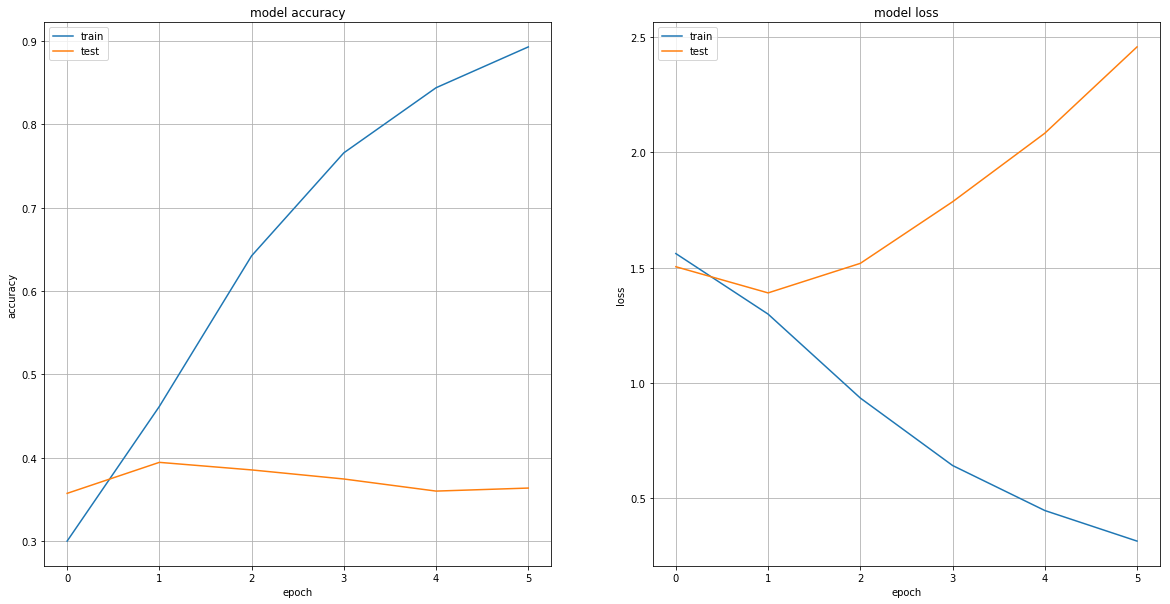

In [15]:
plot_history(history)

In [ ]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

model = keras.models.load_model('best_lstm.hdf5')
Y_test = model.predict(X_test)
lines = '\n'.join([np.argmax(pred) for pred in Y_test])
with open('logreg_lstm_y_test_sst.txt','w') as f:
    f.writelines(lines)

## 4.3 -- innovate !

In [ ]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
